In [2]:
import h5py
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, EarlyStopping

# read DNA sequences data
with h5py.File('/Users/az/OneDrive - University of Houston Downtown/CS 4395 Senior Project/11 Final Senior Project/RNALocator/seq_data_8000_POST.h5', 'r') as h5f:
    data = h5f['seq_data_8000_POST'][:]
    h5f.close()
# print("First 10 characters of the 1st sample: \n",data[0][0:10])
# print("\nTraining data shape: ",data.shape)

# read in the label data
with h5py.File('/Users/az/OneDrive - University of Houston Downtown/CS 4395 Senior Project/11 Final Senior Project/RNALocator/label_data.h5', 'r') as hf:
    label = hf['label_data'][:]
    hf.close()
# print("Labels data shape  : ",label.shape)
# print("\n1st sample's label : ",label[0])

# split dataset into training, validation and testing sets - 70/15/15
# first split 70% into training and 30% into testing
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=42)
# then split 30% of testing set into 15% testing and 15% validation
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=28)

# check data shapes
print("\nx_train shape: ",x_train.shape)
print("y_train shape: ",y_train.shape)
print("-------------")
print("x_val shape: ",x_val.shape)
print("y_val shape: ",y_val.shape)
print("-------------")
print("x_test shape: ",x_test.shape)
print("y_test shape: ",y_test.shape)

Using TensorFlow backend.



x_train shape:  (7961, 8000, 4)
y_train shape:  (7961, 4)
-------------
x_val shape:  (1706, 8000, 4)
y_val shape:  (1706, 4)
-------------
x_test shape:  (1706, 8000, 4)
y_test shape:  (1706, 4)


In [3]:
# Define RNALocator model
def create_model():    
    model=Sequential()
    model.add(Conv1D(filters=32, kernel_size=110, activation='relu', input_shape= (8000, 4)))
    model.add(MaxPooling1D(pool_size=3, strides=3))
    model.add(Dropout(0.2))

    model.add(Conv1D(filters=32, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))
    model.add(Dropout(0.2))

    model.add(Conv1D(filters=32, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))
    model.add(Dropout(0.2))

    model.add(Conv1D(filters=32, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))
    model.add(Dropout(0.2))

    model.add(Conv1D(filters=32, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='kullback_leibler_divergence', metrics=['mae'])
    return model

# Create a model instance
model = create_model()

# Display the model's architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 7891, 32)          14112     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2630, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2630, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2621, 32)          10272     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 873, 32)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 873, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 864, 32)           10272     
__________

In [13]:
# Loads the pretrained weights
checkpoint_path='RNALocator/model_5CNN_LSTM_32_w=110.hdf5'
model.load_weights(checkpoint_path)

# Re-evaluate the model
score_val=model.evaluate(x_val, y_val)
print(f'\nValidation loss: {score_val[0]:.4} / MAE: {score_val[1]:.4}')
# compute Pearson correlation coefficient with NumPy corrcoef function
y_pred=model.predict(x_test)
coeff=np.zeros(4)
for i in range(4):
    coeff[i]=np.corrcoef(y_test[:, i], y_pred[:, i])[0, 1]
print("Pearson correlation coefficient: ", coeff)

1706/1706 [==============================] - 21s 12ms/step

Validation loss: 0.105 / MAE: 0.08681
Pearson correlation coefficient:  [0.67132429 0.60299318 0.54546931 0.52799945]


2.3477862384865125

In [6]:
# print the actual and predicted values
for i in range(len(y_test)):
    print("Actual=%s, \nPredicted=%s" % (y_test[i], y_pred[i]))
    print("---------------------------")

Actual=[0.06558075 0.4914405  0.07153392 0.37144483], 
Predicted=[0.08821864 0.31373933 0.09448481 0.50355726]
---------------------------
Actual=[0.11406913 0.29807295 0.10185782 0.4860001 ], 
Predicted=[0.2050348  0.23566562 0.16706358 0.39223596]
---------------------------
Actual=[0.11387117 0.42027663 0.17275407 0.29309813], 
Predicted=[0.1726889 0.3593574 0.203056  0.2648977]
---------------------------
Actual=[0.54000574 0.07126909 0.33043705 0.05828812], 
Predicted=[0.4031492  0.1542822  0.28614375 0.15642484]
---------------------------
Actual=[0.43906362 0.06163892 0.40978165 0.0895158 ], 
Predicted=[0.30528307 0.15622053 0.27891177 0.2595846 ]
---------------------------
Actual=[0.10319994 0.31847509 0.08616097 0.492164  ], 
Predicted=[0.10217535 0.2457278  0.1360484  0.51604843]
---------------------------
Actual=[0.06651315 0.48082057 0.16328235 0.28938394], 
Predicted=[0.20274651 0.24090344 0.23240064 0.32394943]
---------------------------
Actual=[0.53670243 0.14453727 0

Actual=[0.27527546 0.35084813 0.27513662 0.09873979], 
Predicted=[0.37549835 0.2387821  0.24685186 0.13886769]
---------------------------
Actual=[0.2980794  0.29899904 0.22265565 0.18026591], 
Predicted=[0.26677573 0.13535808 0.19639009 0.40147606]
---------------------------
Actual=[0.2658138  0.12187586 0.28100899 0.33130134], 
Predicted=[0.28621095 0.15685523 0.23024255 0.32669127]
---------------------------
Actual=[0.34782057 0.1302827  0.39926026 0.12263648], 
Predicted=[0.094892   0.18287617 0.1220935  0.60013825]
---------------------------
Actual=[0.05074788 0.1480923  0.08055995 0.72059987], 
Predicted=[0.17793544 0.25548038 0.21171768 0.35486642]
---------------------------
Actual=[0.57559733 0.0441509  0.36047522 0.01977655], 
Predicted=[0.28852546 0.19172381 0.27644524 0.2433056 ]
---------------------------
Actual=[0.16210708 0.22815905 0.10099793 0.50873594], 
Predicted=[0.25969622 0.29226926 0.19436659 0.25366798]
---------------------------
Actual=[0.21869456 0.439634

Actual=[0.49119535 0.07680106 0.39317705 0.03882654], 
Predicted=[0.31891897 0.20536545 0.19717833 0.2785373 ]
---------------------------
Actual=[0.43455724 0.19454467 0.31193255 0.05896555], 
Predicted=[0.21551529 0.34361637 0.23168953 0.20917882]
---------------------------
Actual=[0.34747911 0.24509622 0.29264048 0.11478419], 
Predicted=[0.2973611  0.25810143 0.21469447 0.22984295]
---------------------------
Actual=[0.10767066 0.29307157 0.2115878  0.38766997], 
Predicted=[0.18007152 0.30234557 0.25409374 0.26348925]
---------------------------
Actual=[0.53960979 0.09408145 0.34201973 0.02428904], 
Predicted=[0.26088786 0.29043165 0.2253376  0.22334284]
---------------------------
Actual=[0.12274278 0.51275604 0.16517439 0.19932679], 
Predicted=[0.21244176 0.27372274 0.2258837  0.2879518 ]
---------------------------
Actual=[0.12303164 0.38597157 0.15753229 0.33346449], 
Predicted=[0.14485645 0.23818745 0.17917569 0.4377804 ]
---------------------------
Actual=[0.33444359 0.398243

Predicted=[0.15715553 0.3442236  0.20259546 0.2960254 ]
---------------------------
Actual=[0.45888765 0.19832623 0.2743693  0.06841682], 
Predicted=[0.23150817 0.25938222 0.2545606  0.25454897]
---------------------------
Actual=[0.81295677 0.01054924 0.17227419 0.00421979], 
Predicted=[0.15299553 0.34581527 0.17572425 0.3254649 ]
---------------------------
Actual=[0.21469684 0.2071288  0.16823481 0.40993955], 
Predicted=[0.1054815  0.39438897 0.14899889 0.3511306 ]
---------------------------
Actual=[0.11856223 0.40743414 0.14938452 0.32461911], 
Predicted=[0.22016227 0.3230268  0.17670803 0.28010294]
---------------------------
Actual=[0.1510569  0.45557662 0.25589984 0.13746664], 
Predicted=[0.1586488  0.3636414  0.22275484 0.25495496]
---------------------------
Actual=[0.20281831 0.46671762 0.21544212 0.11502194], 
Predicted=[0.20351881 0.32684192 0.21705304 0.25258628]
---------------------------
Actual=[0.16463884 0.3210011  0.33231162 0.18204844], 
Predicted=[0.18870044 0.326

Actual=[0.53653263 0.07561367 0.30155194 0.08630176], 
Predicted=[0.4471542  0.15649001 0.27178273 0.12457307]
---------------------------
Actual=[0.25299451 0.12548686 0.21779584 0.40372279], 
Predicted=[0.31652942 0.14730138 0.24536678 0.29080245]
---------------------------
Actual=[0.11775887 0.31674608 0.17868555 0.38680949], 
Predicted=[0.1157507  0.40985325 0.16202125 0.31237483]
---------------------------
Actual=[0.55704479 0.05192063 0.34847003 0.04256456], 
Predicted=[0.3455979  0.19404234 0.23945004 0.2209097 ]
---------------------------
Actual=[0.31130003 0.22577403 0.32884898 0.13407695], 
Predicted=[0.20288253 0.23955734 0.26012215 0.29743803]
---------------------------
Actual=[0.27220147 0.41779266 0.15093746 0.15906841], 
Predicted=[0.29424292 0.28858507 0.20332411 0.21384789]
---------------------------
Actual=[0.31032444 0.17967885 0.42378363 0.08621309], 
Predicted=[0.35524392 0.2142359  0.24833477 0.18218544]
---------------------------
Actual=[0.39001526 0.173415

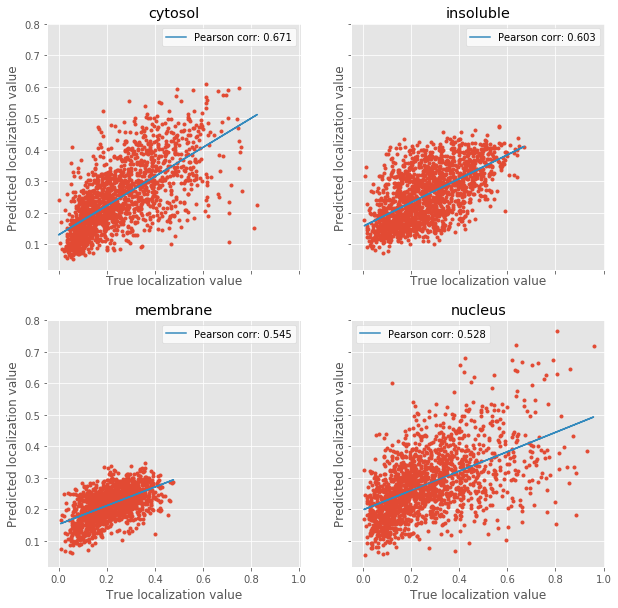

In [12]:
import matplotlib.pyplot as plt
import scipy.stats
# plt.style.use('ggplot')

cytosol_true=y_test[:, 0]
insoluble_true=y_test[:,1]
membrane_true=y_test[:,2]
nucleus_true=y_test[:,3]

cytosol_pred=y_pred[:, 0]
insoluble_pred=y_pred[:,1]
membrane_pred=y_pred[:,2]
nucleus_pred=y_pred[:,3]

slope, intercept, r, p, stderr = scipy.stats.linregress(cytosol_true, cytosol_pred)
fig, ax = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
ax[0,0].plot(cytosol_true, cytosol_pred, linewidth=0, marker='.')
ax[0,0].plot(cytosol_true, intercept + slope * cytosol_true, label=f'Pearson corr: {r:.3f}')
ax[0,0].set_xlabel('True localization value')
ax[0,0].set_ylabel('Predicted localization value')
ax[0,0].set_title("cytosol")
ax[0,0].legend(facecolor='white')

slope2, intercept2, r2, p2, stderr2 = scipy.stats.linregress(insoluble_true, insoluble_pred)
ax[0,1].plot(insoluble_true, insoluble_pred, linewidth=0, marker='.')
ax[0,1].plot(insoluble_true, intercept2 + slope2 * insoluble_true, label=f'Pearson corr: {r2:.3f}')
ax[0,1].set_xlabel('True localization value')
ax[0,1].set_ylabel('Predicted localization value')
ax[0,1].set_title("insoluble")
ax[0,1].legend(facecolor='white')

slope3, intercept3, r3, p3, stderr3 = scipy.stats.linregress(membrane_true, membrane_pred)
ax[1,0].plot(membrane_true, membrane_pred, linewidth=0, marker='.')
ax[1,0].plot(membrane_true, intercept3 + slope3 * membrane_true, label=f'Pearson corr: {r3:.3f}')
ax[1,0].set_xlabel('True localization value')
ax[1,0].set_ylabel('Predicted localization value')
ax[1,0].set_title("membrane")
ax[1,0].legend(facecolor='white')

slope4, intercept4, r4, p4, stderr4 = scipy.stats.linregress(nucleus_true, nucleus_pred)
ax[1,1].plot(nucleus_true, nucleus_pred, linewidth=0, marker='.')
ax[1,1].plot(nucleus_true, intercept4 + slope4 * nucleus_true, label=f'Pearson corr: {r4:.3f}')
ax[1,1].set_xlabel('True localization value')
ax[1,1].set_ylabel('Predicted localization value')
ax[1,1].set_title("nucleus")
ax[1,1].legend(facecolor='white')
plt.savefig('PCC.png')
plt.show()